In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split

In [92]:
sns.set_theme()

Remarks
- No date of transaction (wtf)

Hypotheses
- Price of sell is negociated at -10% max
- Chambres NA with Pièces 1 can be replaced by 0. It can be considered as 'Chambre séparée', which is not the case in a studio
- High precision of Superficie, when multiple rows, is considered outlier (i.e. 24.00030284m2 should be a single row that might have been duplicated)

Improve
- Better imputation of Chambres NA with 3 & 4 Pièces (deleted 8%! of whole data here)

# Load data

In [93]:
prices = pd.read_csv('Prix IDF.xlsx - Prix.csv')
rentals = pd.read_csv('Prix IDF.xlsx - Loyer.csv')

In [94]:
prices.shape

(44685, 6)

In [95]:
prices.head()

,Code Postal,Ville,Pièces,Chambres,Superficie,Prix de vente
0,75001,PARIS,3,2.0,93,1680000.0
1,75001,PARIS,3,2.0,"87,4",1295000.0
2,75001,PARIS,5,4.0,"115,19",1905000.0
3,75001,PARIS,4,4.0,"93,5",1177000.0
4,75001,PARIS,2,1.0,54,870000.0


In [96]:
rentals.shape

(16014, 7)

In [97]:
rentals.head()

,Unnamed: 0,Code Postal,Ville,Pièces,Chambres,Superficie,Loyer
0,0,75001,PARIS,3,1.0,71,2150
1,1,75001,PARIS,2,1.0,35,1600
2,2,75001,PARIS,2,1.0,50,2515
3,3,75001,PARIS,1,NaN,35,1380
4,4,75001,PARIS,2,1.0,42,1700


# Clean data

## General 

In [98]:
# Drop dead column
rentals.drop(['Unnamed: 0'], axis=1, inplace=True)

In [99]:
# Rename columns
prices.columns = ['Code_postal', 'Ville', 'Pièces', 'Chambres', 'Superficie', 'Prix_de_vente']
rentals.columns = ['Code_postal', 'Ville', 'Pièces', 'Chambres', 'Superficie', 'Loyer']

In [100]:
# Replace commas by points
prices = prices.replace(to_replace=',', value='.', regex=True)
rentals = rentals.replace(to_replace=',', value='.', regex=True)

## Cast

Cast variables into:
- Code_postal: category
- Ville: category
- Pièces: int
- Chambres: int  (TODO when NANs are imputed)
- Superficie: float
- Loyer: int
- Prix_de_vente: float

### Cast categories

In [101]:
# Cast Code_postal as category
prices['Code_postal'] = prices['Code_postal'].astype('category')
rentals['Code_postal'] = rentals['Code_postal'].astype('category')

# Cast Ville as category
prices['Ville'] = prices['Ville'].astype('category')
rentals['Ville'] = rentals['Ville'].astype('category')

### Cast Pièces (and clean)

In [102]:
# Get outliers
p_out = [val for val in prices['Pièces'] if float(val) != round(float(val))]
r_out = [val for val in rentals['Pièces'] if float(val) != round(float(val))]
print('prices', p_out)
print('rentals', r_out)

prices ['25.44', '54.54', '17.46', '130.44', '63.72', '194.56', '47.89']
rentals []


Prices:
- Few outliers
- Round to closest (as no importance) the outliers to cast as int
- Fun fact: only 1 house sold having 13 rooms. Whereas 20 and 6 were sold having 12 and 14 rooms respectivelly
- Max rooms in a sell: 195

Rentals:
- No outlier
- Max rooms in a rental: 20

In [103]:
# Prices: Cast from object to float
prices['Pièces'] = prices['Pièces'].astype('float64')
# Prices: Round
prices['Pièces'] = prices['Pièces'].apply(round)

In [104]:
# Cast to int64
prices['Pièces'] = prices['Pièces'].astype('int64')
rentals['Pièces'] = rentals['Pièces'].astype('int64')

### Cast Superficie

In [105]:
# a = prices['Superficie'].astype('float64', errors='ignore')
err = []
for v in prices['Superficie']:
    try:
        float(v)
    except:
        err.append(v)

In [106]:
err

['²1', '²1', '²1', '²1', '²1']

In [107]:
# Analyse errors
prices[prices['Superficie'] == '²1']

,Code_postal,Ville,Pièces,Chambres,Superficie,Prix_de_vente
34824,93300,Aubervilliers,55,NaN,²1,210000.0
34825,93300,Aubervilliers,17,NaN,²1,96000.0
34827,93300,Aubervilliers,64,NaN,²1,234000.0
34828,93300,Aubervilliers,195,NaN,²1,738000.0
34829,93300,Aubervilliers,48,NaN,²1,186000.0


- These are errors definitely, since houses with +17 rooms are incoherent with these prices
- Drop these outliers

In [108]:
# Drop outliers
ma_no_outliers = prices['Superficie'] == '²1'
prices = prices[~ma_no_outliers]

In [109]:
# Cast to float
prices['Superficie'] = prices['Superficie'].astype('float64')
rentals['Superficie'] = rentals['Superficie'].astype('float64')

### Cast Loyer to int64

In [110]:
rentals['Loyer'] = rentals['Loyer'].astype('int64')

### Cast Prix_de_vente

In [111]:
prices['Prix_de_vente'] = prices['Prix_de_vente'].astype('float64')

## Missing (NaN)

### NA Prix_de_vente
- 1 missing
- Dropped it
- if time left, impute it

In [112]:
# Prix_de_vente
ma_out_px = prices['Prix_de_vente'].isna()
prices[ma_out_px]

,Code_postal,Ville,Pièces,Chambres,Superficie,Prix_de_vente
38429,94100,Saint-Maur-des-Fossés,4,3.0,87.0,NaN


In [113]:
# Drop na
prices = prices[~ma_out_px]

### NA Chambres
- Some advertisements have many rooms, with might be explained by large rooms counting as multiple rooms [https://www.logic-immo.com/vendre/estimer-bien-immobilier/calculer-nombre-pieces-maison-appartement-1-20-40](cf)

Prices:
- NAs with Pièces <=2
- +8000 NAs with Pièces > 2

Rentals:
- Mostly NAs with Pièces <=2
- 71 NAs with Pièces > 2

Imputations:
- 0 when Pièces = 1
- 1 when Pièces = 2
- Dropped otherwise (can't tell whether Pièces or Chambres is wrong)

#### Study Prices

##### Analysis

(0.0, 200.0)

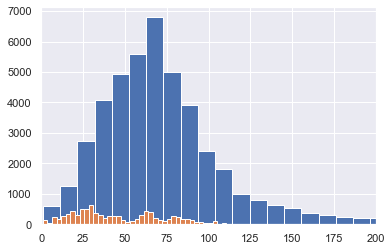

In [114]:
prices['Superficie'].hist(bins=150)
ma_na_chamb = prices['Chambres'].isna()
prices[ma_na_chamb]['Superficie'].hist(bins=150)
plt.xlim([0, 200])

(0.0, 10.0)

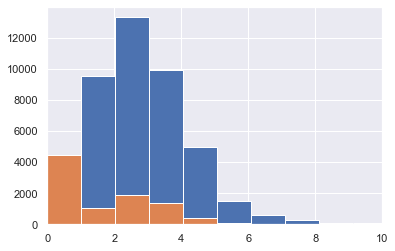

In [115]:
prices['Pièces'].hist(bins=150)
ma_na_pieces = prices['Chambres'].isna()
prices[ma_na_pieces]['Pièces'].hist(bins=150)
plt.xlim([0, 10])

- When missing and 1 Pièces only, it is a studio, and can be replaced by 0
- When there are 2 Pièces, NaN can be replaced by 1.
- For > 2 Pièces, its hard to tell.

In [116]:
# Distribution of Chambres for 3 Pièces
ma_pieces_px_3 = prices['Pièces'] == 3
prices[ma_pieces_px_3]['Chambres'].value_counts

<bound method IndexOpsMixin.value_counts of 0        2.0
1        2.0
5        2.0
9        1.0
14       2.0
        ... 
44666    NaN
44670    2.0
44672    2.0
44676    2.0
44682    2.0
Name: Chambres, Length: 13315, dtype: float64>

- Chambres > 4 are obvious outliers
- Chambres = 3 & 4 are difficult to interpret. It might as well be an error in the number of Chambres than Pièces

<AxesSubplot:>

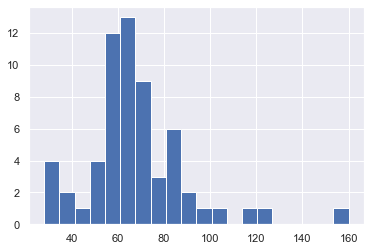

In [117]:
# Distribution Superficie for 3 Chambres 3 Pièces
ma_pieces_px_3 = prices['Pièces'] == 3
ma_chambres_px_3 = prices['Chambres'] == 3
prices[ma_pieces_px_3 & ma_chambres_px_3]['Superficie'].hist(bins=20)

- Although it is concentrated around 60m2, it is hard to tell whether it might have 3 Chambres or 2 Chambres
- Drop these records

##### Impute!

In [118]:
# Impute Chambre NA with 0 when Pièces is 1
ma_na_pieces_px = prices['Chambres'].isna()
ma_n_pieces_px_1 = prices['Pièces'] == 1
prices.loc[ma_na_pieces_px & ma_n_pieces_px_1, 'Chambres'] = 0

In [119]:
# Impute Chambre NA with 1 when Pièces is 2
ma_n_pieces_px_2 = prices['Pièces'] == 2
prices.loc[ma_na_pieces_px & ma_n_pieces_px_2, 'Chambres'] = 1

In [120]:
# /!\ Drop Chambre NA when Pièces > 2 (since hard to tell what it should be)
# /!\ Large data loss here
ma_na_pieces_px = prices['Chambres'].isna()
ma_n_pieces_px_large = prices['Pièces'] > 2
ma_idx_px_na = prices[ma_na_pieces_px & ma_n_pieces_px_large].index
prices.drop(ma_idx_px_na, inplace=True)

In [121]:
# Control NA are dropped (Not!)
prices[prices['Chambres'].isna()]

,Code_postal,Ville,Pièces,Chambres,Superficie,Prix_de_vente
30817,93100,Montreuil,0,NaN,363.0,747000.0
30947,93100,Montreuil,0,NaN,363.0,747000.0
44290,78000,Versailles,0,NaN,214.0,766500.0
44411,78000,Versailles,0,NaN,214.0,766500.0
44425,78000,Versailles,0,NaN,214.0,766500.0
44546,78000,Versailles,0,NaN,214.0,766500.0
44587,78000,Versailles,0,NaN,214.0,766500.0


In [122]:
# Control these NA come from Pièces being 0 (i.e. outliers) (Yes!)
prices[prices['Pièces'] == 0]

,Code_postal,Ville,Pièces,Chambres,Superficie,Prix_de_vente
30817,93100,Montreuil,0,NaN,363.0,747000.0
30947,93100,Montreuil,0,NaN,363.0,747000.0
44290,78000,Versailles,0,NaN,214.0,766500.0
44411,78000,Versailles,0,NaN,214.0,766500.0
44425,78000,Versailles,0,NaN,214.0,766500.0
44546,78000,Versailles,0,NaN,214.0,766500.0
44587,78000,Versailles,0,NaN,214.0,766500.0


In [123]:
# Drop remaining Chambres NAs
ma_chambre_px_na_r = prices[prices['Chambres'].isna()]
ma_chambre_px_na_r_idx = ma_chambre_px_na_r.index
prices.drop(ma_chambre_px_na_r_idx, inplace=True)

#### Study Rentals

(0.0, 8.0)

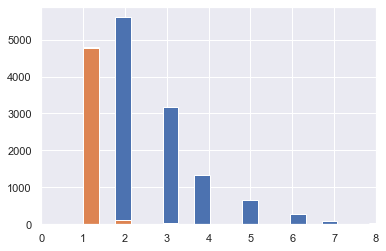

In [124]:
rentals['Pièces'].hist(bins=50)
ma_na_pieces_rent = rentals['Chambres'].isna()
rentals[ma_na_pieces_rent]['Pièces'].hist(bins=50)
plt.xlim([0, 8])

- There is an even clearer pattern, with missing Chambres representing studios
- NAs when 2 Chambres must be replaced by 1
- NAs can (almost all) be imputed with a 0 (or 1, to think) but surely < 2

In [125]:
# Impute Chambre NA with 1 when Pièces is 2
ma_na_pieces_rent = rentals['Chambres'].isna()
ma_n_pieces_2 = rentals['Pièces'] == 2
rentals.loc[ma_na_pieces_rent & ma_n_pieces_2, 'Chambres'] = 1

In [126]:
# Impute Chambre NA with 0 when Pièces is 1
ma_n_pieces_1 = rentals['Pièces'] == 1
rentals.loc[ma_na_pieces_rent & ma_n_pieces_1, 'Chambres'] = 0

In [127]:
# Drop when Pièces > 2 (71 NAs)
ma_na_ch_rent = rentals['Chambres'].isna()
rentals[ma_na_ch_rent]['Pièces'].value_counts()

3     45
4     17
5      4
6      1
7      1
9      1
10     1
20     1
Name: Pièces, dtype: int64

In [128]:
ma_na_ch_rent_idx = rentals[ma_na_ch_rent].index
rentals.drop(ma_na_ch_rent_idx, inplace=True)

### NA Superficie
- Prices: 25 NAs remaining
- Rentals: 27 NAs remaining

Imputation:
- Dropped, too complex to impute (range between large range of Loyer from 500 to 1200)

In [129]:
rentals.isna().sum()

Code_postal     0
Ville           0
Pièces          0
Chambres        0
Superficie     27
Loyer           0
dtype: int64

In [130]:
prices.isna().sum()

Code_postal       0
Ville             0
Pièces            0
Chambres          0
Superficie       25
Prix_de_vente     0
dtype: int64

- Drop Superficie NAs (too risky to impute a value - mean would be worse than dropped)

In [131]:
# Prices
ma_sup_px_na = prices['Superficie'].isna()
idx = prices[ma_sup_px_na].index
prices.drop(idx, inplace=True)

In [132]:
# Rentals
ma_sup_rent_na = rentals['Superficie'].isna()
idx = rentals[ma_sup_rent_na].index
rentals.drop(idx, inplace=True)

## Cast Chambres

In [133]:
prices['Chambres'] = prices['Chambres'].astype('int64')
rentals['Chambres'] = rentals['Chambres'].astype('int64')

In [134]:
# Clean!
rentals.dtypes

Code_postal    category
Ville          category
Pièces            int64
Chambres          int64
Superficie      float64
Loyer             int64
dtype: object

## Outliers
- Drop samples with Superficie lower than 8 (price and superficie doesn't help, investigate further)
- Drop samples with var > med + 3std for:
    - Superficie
    - Chambres (for Prices)
    - Pièces
    - Loyers
    - Prix_de_vente
- Drop samples with Chambres > q99

In [135]:
def get_high_outliers(data, col, n_std=3):
    """
    Get the value at 3std of the median along with 
    idx corresponding to outliers
    """
    med = data[col].median()
    std = data[col].std()
    up_val = med + n_std * std
    
    ma = data[col] > up_val
    idx = data[ma].index
    n_samples = idx.shape[0]
    return idx, up_val, n_samples

### Low Superficie
- Drop all below 8m2 since too hard to differentiate between outliers and true data (based on a price analysis, since the price range is large)

#### Prices

In [136]:
ma_sfcie_low = prices['Superficie'] < 8
prices[ma_sfcie_low]['Chambres'].value_counts()

0    154
1     47
Name: Chambres, dtype: int64

(60000.0, 1000000.0)

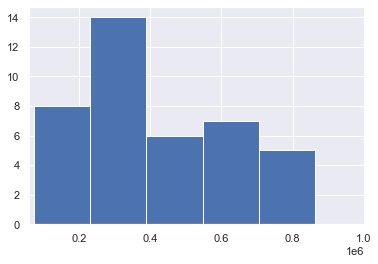

In [137]:
ma_sfcie_low = prices['Superficie'] < 8
ma_chm_1 = prices['Chambres'] == 1
prices[ma_sfcie_low & ma_chm_1]['Prix_de_vente'].hist()
plt.xlim([60000, 1000000])

- Too complex to impute (it might correspond to announces that disrupt the system to be shown to everyone - prevent to be filtered out because of its large superficie)
- Drop it!

In [138]:
# Drop all
idx = prices[ma_sfcie_low].index
prices.drop(idx, inplace=True)

#### Rentals

<AxesSubplot:>

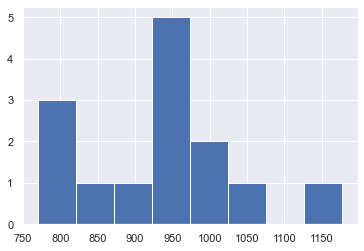

In [139]:
ma_sfcie_low = rentals['Superficie'] < 8
ma_chm_1 = rentals['Chambres'] == 1
rentals[ma_sfcie_low & ma_chm_1]['Loyer'].hist(bins=8)

- Too complex to impute
- Drop it!

In [140]:
# Drop when Superficie < 8
idx = rentals[ma_sfcie_low].index
rentals.drop(idx, inplace=True)

### High Superficie
- Use med+3std as separator
- Drop above

#### Prices

In [141]:
idx_out_sup, up_val, n_samples = get_high_outliers(prices, 'Superficie')
print('3std val:', up_val)
print('N samples:', n_samples)

3std val: 217.90037641776348
N samples: 923


In [142]:
prices.drop(idx_out_sup, inplace=True)

#### Rentals

In [143]:
idx_out_sup, up_val, n_samples = get_high_outliers(rentals, 'Superficie')
print('3std val:', up_val)
print('N samples:', n_samples)

3std val: 164.51661820953476
N samples: 411


In [144]:
rentals.drop(idx_out_sup, inplace=True)

### Pièces
- Use med+3std as separator
- Drop above

#### Prices

In [145]:
idx_out_sup, up_val, n_samples = get_high_outliers(prices, 'Pièces')
print('3std val:', up_val)
print('N samples:', n_samples)

3std val: 7.405460946337437
N samples: 76


In [146]:
prices.drop(idx_out_sup, inplace=True)

#### Rentals

In [147]:
idx_out_sup, up_val, n_samples = get_high_outliers(rentals, 'Pièces')
print('3std val:', up_val)
print('N samples:', n_samples)

3std val: 5.367267193304574
N samples: 107


In [148]:
rentals.drop(idx_out_sup, inplace=True)

### Chambres
- Use med+3std as separator for Prices
- Drop above for Prices
- For Rentals: Use q99 instead to drop high ouliers, since highest drives the std too much to use 3std separator.

#### Prices

In [149]:
idx_out_sup, up_val, n_samples = get_high_outliers(prices, 'Chambres')
print('3std val:', up_val)
print('N samples:', n_samples)

3std val: 5.542683545749061
N samples: 26


In [150]:
prices.drop(idx_out_sup, inplace=True)

#### Rentals

In [151]:
idx_out_sup, up_val, n_samples = get_high_outliers(rentals, 'Chambres')
print('3std val:', up_val)
print('N samples:', n_samples)

3std val: 807.4458572221045
N samples: 1


- Highest is so extreme it explodes the std
- use quantile instead

In [152]:
q99 = rentals['Chambres'].quantile(0.99)
q99

4.0

In [153]:
ma = rentals['Chambres'] > q99
rentals[ma].shape
idx_out_sup = rentals[ma].index

In [154]:
rentals.drop(idx_out_sup, inplace=True)

### Prix de vente
- Use med+3std as separator
- Drop above

#### Prices

In [155]:
prices['Prix_de_vente'].describe()

count    3.960900e+04
mean     6.895758e+05
std      6.516807e+05
min      1.100000e+01
25%      2.990000e+05
50%      4.750000e+05
75%      8.200000e+05
max      1.050000e+07
Name: Prix_de_vente, dtype: float64

In [156]:
q99 = prices['Prix_de_vente'].quantile(.99)
q99

3200000.0

In [157]:
ma = prices['Prix_de_vente'] > q99
idx_out_sup = prices[ma].index
prices[ma]

,Code_postal,Ville,Pièces,Chambres,Superficie,Prix_de_vente
12,75001,PARIS,4,2,207.00,5200000.0
37,75001,PARIS,4,2,207.00,5200000.0
58,75001,PARIS,6,4,155.07,3225000.0
72,75001,PARIS,5,2,176.00,5500000.0
83,75001,PARIS,6,4,155.07,3225000.0
...,...,...,...,...,...,...
23896,92200,Neuilly-sur-Seine,6,4,216.00,3325000.0
23973,92200,Neuilly-sur-Seine,5,3,179.25,4635000.0
24037,92200,Neuilly-sur-Seine,6,4,216.00,3325000.0
24061,92200,Neuilly-sur-Seine,6,4,187.00,3400000.0


In [158]:
prices.drop(idx_out_sup, inplace=True)

#### Rentals

In [159]:
rentals['Loyer'].describe()

count    15361.000000
mean      1528.786017
std       1316.250298
min        300.000000
25%        877.000000
50%       1200.000000
75%       1784.000000
max      99714.000000
Name: Loyer, dtype: float64

In [160]:
idx_out_sup, up_val, n_samples = get_high_outliers(rentals, 'Loyer', n_std=2)
print('3std val:', up_val)
print('N samples:', n_samples)

3std val: 3832.5005959972987
N samples: 640


In [161]:
rentals.drop(idx_out_sup, inplace=True)

## Duplicates

In [162]:
r = prices.groupby(['Superficie', 'Prix_de_vente']).size()
r[r>1].value_counts()

2     5822
3     1352
4      601
5      196
6      101
7       49
8       20
9        9
11       3
10       3
50       1
58       1
34       1
20       1
12       1
23       1
87       1
dtype: int64

- Many duplicates, but could be real data, since a similar Superficie is logically sold at a similar price

In [163]:
# Inspect further by crossing with Code_postal TODO
r[r>10]

Superficie  Prix_de_vente
29.48       183000.0         20
30.00       450000.0         12
45.00       334000.0         34
46.00       540000.0         11
56.02       728000.0         11
64.00       210000.0         50
83.53       308800.0         87
96.00       425000.0         58
98.24       420000.0         23
100.00      1250000.0        11
dtype: int64

- Since no one could input twice a higly precise Superficie like 83.529999
- From these strange Superficie, one entry must be kept only (e.g. 1 of the 87)

# Further analysis

In [164]:
# profile_prices = ProfileReport(prices, title="Prices report")
# profile_prices.to_notebook_iframe()

Prices report analysis

- Many duplicated rows 21.6%. These are transactions and should not be treated as duplicates. With these variables, it is probable enough to have similar houses sold at the same price
- 'Chambres' is the only variable with missing values
- 'Ville' represents IDF, with Paris at 41.5%. 122 different cities (paris included)
- Code_postal 141 vs Ville 122. There exists multiple Code_postal in Paris (20)



Rentals report analysis

- 'Ville' also IDF, with 121 cities

Prices vs Rentals
- 1 ville / Code_postal de moins dans rentals (vs prices) (92230, Gennevilliers)

### General

In [165]:
code_px = prices['Code_postal'].unique()
code_rent = rentals['Code_postal'].unique()
[code for code in code_px if code not in code_rent]

[92230]

Text(0.5, 0.98, 'Relation entre variables et nombre de pièces')

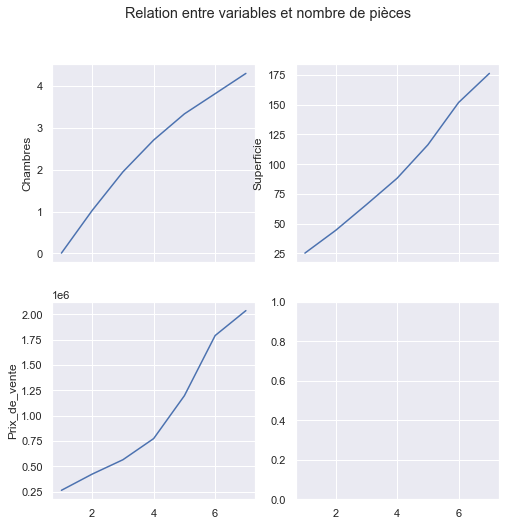

In [166]:
m = prices.groupby('Pièces').mean()
c = m.columns.copy()

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(8,8))


axs[0, 0].plot(m.index, m[c[0]])
axs[0, 0].set_ylabel(c[0])

axs[0, 1].plot(m.index, m[c[1]])
axs[0, 1].set_ylabel(c[1])

axs[1, 0].plot(m.index, m[c[2]])
axs[1, 0].set_ylabel(c[2])

plt.suptitle("Relation entre variables et nombre de pièces")

<AxesSubplot:>

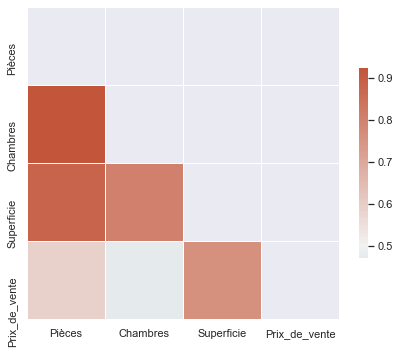

In [167]:
corr = prices.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(7, 7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


### Plot map Paris

## Split Train and Test sets

### Rentals

In [168]:
features = rentals.columns.drop('Loyer')
rentals_target = 'Loyer'
prices_target = 'Prix_de_vente'

X_rentals = rentals[features]
y_rentals = rentals[rentals_target]
X_prices = prices[features]
y_prices = prices[prices_target]

In [169]:
X_rentals_train, X_rentals_test, y_rentals_train, y_rentals_test = train_test_split(X_rentals, y_rentals, test_size=.33, random_state=42)
X_prices_train, X_prices_test, y_prices_train, y_prices_test = train_test_split(X_prices, y_prices, test_size=.33, random_state=42)

In [170]:
rentals_train = pd.concat([X_rentals_train, y_rentals_train], axis=1)
prices_train = pd.concat([X_prices_train, y_prices_train], axis=1)

rentals_test = pd.concat([X_rentals_test, y_rentals_test], axis=1)
prices_test = pd.concat([X_prices_test, y_prices_test], axis=1)

## Rentability

r = (Loyer * 12) / Prix_de_vente

In [503]:
def compute_x_by_y(prices, rentals,
                   x='Superficie', y='Code_postal',
                   sup_min=8, sup_max=14):
    """
    Compute rentability while filtering the Superficie
    
    The risk is not computed as the volatility of prices since it would make no sense.
    The risk is thus approximated with the relative num of annoucements / num of sells
    """
    # Weight the risk to adjust the return (train it?)
    w = 1

    # Create x filters (e.g. filter by Superficie < 14)
    ma_min_px = prices[x] > sup_min
    ma_max_px = prices[x] < sup_max
    ma_min_rent = rentals[x] > sup_min
    ma_max_rent = rentals[x] < sup_max
    
    # Group by y: agg with mean
    mean_px = prices[ma_min_px & ma_max_px].groupby(y).mean()
    mean_rent = rentals[ma_min_rent & ma_max_rent].groupby(y).mean()

    # Group by y: agg with count
    count_px = prices[ma_min_px & ma_max_px].groupby(y).count()
    count_rent = rentals[ma_min_rent & ma_max_rent].groupby(y).count()

    # Temp df
    rentals_norm = rentals.copy()
    
    # Normalize
    min = rentals['Loyer'].min()
    max = rentals['Loyer'].max()
    rentals_norm['Loyer'] = rentals['Loyer'].apply(lambda x: ((x-min) / (max-min)))

    # Group by y: agg with std
    std_rent_norm = rentals_norm[[y, 'Loyer']][ma_min_rent & ma_max_rent].groupby(y).std()

    # Compute return and risk
    r = (mean_rent['Loyer'] * 12) / mean_px['Prix_de_vente']
    risk = std_rent_norm['Loyer']

    # Compute ratio
    ratio = r/(risk * w)

    return r, risk, ratio, mean_px, mean_rent, count_px, count_rent

### Recommendation for interesting areas in the case of <14m2 flats

In [504]:
results = compute_x_by_y(prices_train, rentals_train, sup_max=14)
r, risk, ratio, mean_px, mean_rent, count_px, count_rent = results

In [505]:
count_rent[count_rent['Loyer'] > 5]['Loyer']

Code_postal
75007    12
75008    13
75009    11
75010    15
75014     6
75015     7
75016    36
75017    26
75018    10
75019     6
78000     6
92100    11
92200    15
93100     6
Name: Loyer, dtype: int64

- 75016: 61, le plus élevé car plein de chambres de bonnes
- manque depuis combien de temps l'annonce a été postée:
    - car si vient d'être postée, cela signifie qu'il y a simplement du turnover (ou que les proprios se mettent à louer leur appart de chambre de bonne)
    - si l'annonce est ancienne, ça indique qu'il y a une potentielle sur-offre

In [506]:
ret = pd.concat([r, risk, ratio], axis=1)
ret.columns = ['returns', 'risk', 'ratio']
ret_clean = ret[~ret['returns'].isna()]

No handles with labels found to put in legend.


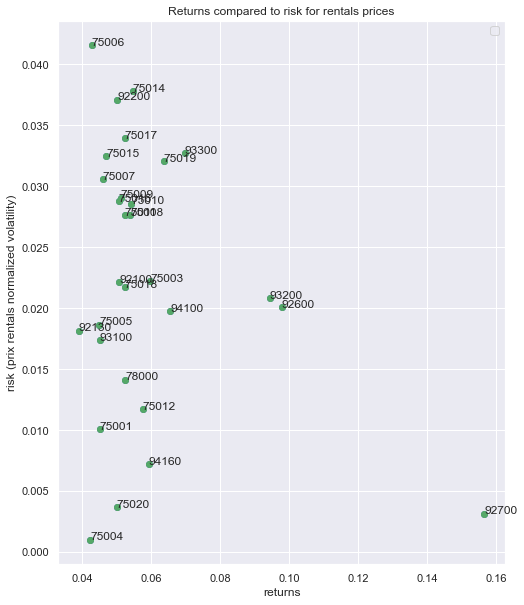

In [507]:
# Plot
plt.figure(figsize=(8, 10))
plt.scatter(ret_clean['returns'], ret_clean['risk'])
plt.xlabel('returns')
plt.ylabel('risk (prix rentals normalized volatility)')
plt.title('Returns compared to risk for rentals prices')

# Annotate opportunities
for idx, r, risk in zip(ret_clean.index, ret_clean['returns'], ret_clean['risk']):
    # Add value on graph
    plt.annotate(idx, (r, risk))

    # Great
    if risk > 100:
        plt.plot(r, risk, 'ro')

    # Bad opportunity
    if risk < 60:
        plt.plot(r, risk, 'go')

plt.legend()

- Careful in the interpretation: an area with many sells will be considered a good area,  although it might be a bad signal in reality?

In [508]:
# TODO plot on a IDF map

### Recommendation for interesting areas averaged

In [509]:
flat_types = {
    'small_low': [7, 15],
    'small_high': [15, 25],
    'medium_low': [25, 45],
    'medium_high': [45, 70],
    'big_low': [70, 110],
    'big_high': [110, 200],
}

In [510]:
r_tot = []
risk_tot = []
ratio_tot = []
count_tot = []

for type, (low, high) in flat_types.items():
    results = compute_x_by_y(prices_train, rentals_train, sup_min=low, sup_max=high)
    r, risk, ratio, mean_px, mean_rent, count_px, count_rent = results
    r_tot.append(r)
    risk_tot.append(risk)
    ratio_tot.append(ratio)
    count_tot.append(count_rent)


In [511]:
r_concat = pd.concat(r_tot, axis=1)
risk_concat = pd.concat(risk_tot, axis=1)
ratio_concat = pd.concat(ratio_tot, axis=1)
count_concat = pd.concat(count_tot, axis=1)

In [512]:
r_mean = r_concat.mean(axis=1)
risk_mean = risk_concat.mean(axis=1)
ratio_mean = ratio_concat.mean(axis=1)
count_mean = count_concat.mean(axis=1)

In [513]:
ret_mean = pd.concat([r_mean, risk_mean, ratio_mean], axis=1)
ret_mean.columns = ['returns', 'risk', 'ratio']
ret_mean_clean = ret_mean[~ret_mean['returns'].isna()]

No handles with labels found to put in legend.


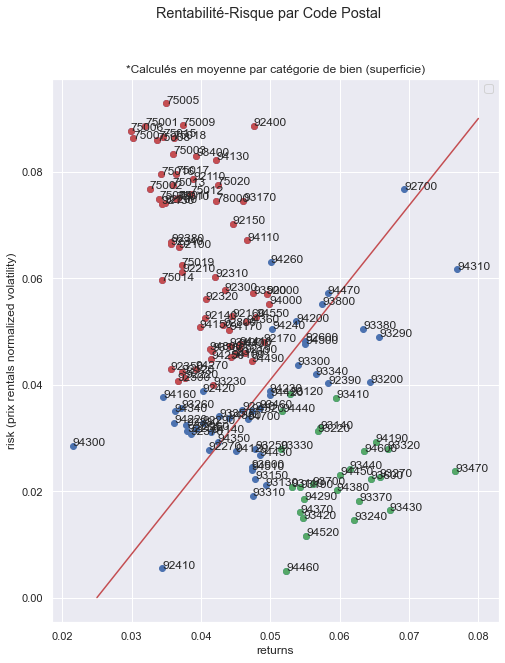

In [518]:
# Plot
plt.figure(figsize=(8, 10))
plt.scatter(ret_mean_clean['returns'], ret_mean_clean['risk'])
plt.xlabel('returns')
plt.ylabel('risk (prix rentals normalized volatility)')
plt.title('*Calculés en moyenne par catégorie de bien (superficie)')
plt.suptitle("Rentabilité-Risque par Code Postal")

plt.plot([.025, .08], [0, .09], 'r-')

# Annotate opportunities
for idx, r, risk in zip(ret_mean_clean.index, ret_mean_clean['returns'], ret_mean_clean['risk']):
    # Add value on graph
    plt.annotate(idx, (r, risk))

    # Great
    if risk > .04 and r < .05:
        plt.plot(r, risk, 'ro')

    # Bad opportunity
    if risk < .04 and r > .05:
        plt.plot(r, risk, 'go')

plt.legend()

## Feature Engineering

### Add returns, risk and ratio

- Add measures to train and test
- Measures have been carefully built on train set only to prevent data leakage

In [176]:
rentals_train_aug = pd.merge(rentals_train, ret_clean, how='left', on='Code_postal')
rentals_test_aug = pd.merge(rentals_test, ret_clean, how='left', on='Code_postal')

prices_train_aug = pd.merge(prices_train, ret_clean, how='left', on='Code_postal')
prices_test_aug = pd.merge(prices_test, ret_clean, how='left', on='Code_postal')

### Add Paris

- No risk of data leakage

In [177]:
def is_paris(x):
    answer = 1 if x.lower() == 'paris' else 0
    return answer

# Add Paris
rentals_train_aug['Paris'] = rentals_train_aug['Ville'].apply(is_paris)
rentals_test_aug['Paris'] = rentals_test_aug['Ville'].apply(is_paris)

prices_train_aug['Paris'] = prices_train_aug['Ville'].apply(is_paris)
prices_test_aug['Paris'] = prices_test_aug['Ville'].apply(is_paris)

# Drop Ville
rentals_train_aug.drop('Ville', axis=1, inplace=True)
rentals_test_aug.drop('Ville', axis=1, inplace=True)

prices_train_aug.drop('Ville', axis=1, inplace=True)
prices_test_aug.drop('Ville', axis=1, inplace=True)

### Hype: based on high price Code Postal

- Compute on train to prevent data leakage

In [178]:
# data_aug['Loyer'].isna()

# small = data_aug['Superficie'] < 20
# d = data_aug[small].groupby('Code_postal').mean()['Loyer']
# d.isna().sum()

In [179]:
# d.describe()

# Export data

In [180]:
rentals_train_aug.to_csv('rentals_train_aug.csv', index=False)
rentals_test_aug.to_csv('rentals_test_aug.csv', index=False)
prices_train_aug.to_csv('prices_train_aug.csv', index=False)
prices_test_aug.to_csv('prices_test_aug.csv', index=False)

# Control coherence of predictions

In [186]:
ma_14 = rentals['Superficie'] == 14
ma_75013 = rentals['Code_postal'] == 75013
ma_75016 = rentals['Code_postal'] == 75016
print('75013:', rentals[ma_14 & ma_75013]['Loyer'].mean())
print('75016:', rentals[ma_14 & ma_75016]['Loyer'].mean())

75013: 640.0
75016: 731.0


In [204]:
ma_11 = rentals['Superficie'] == 14
ma_75013 = rentals['Code_postal'] == 75013
ma_75016 = rentals['Code_postal'] == 75016
print('75013:', rentals[ma_11 & ma_75013]['Loyer'].mean())
print('75016:', rentals[ma_11 & ma_75016]['Loyer'].mean())

75013: 640.0
75016: 731.0
